### Lab 1c: 100m Space Telescope

9/18/24

**Goals:**

* **Physical Optics Propagation** package in Python

  * Investigate impact of different aperture geometries on the PSF profile

  * Plot 1-D intensity profile distribution and compare to theoretical value (Airy Function)

  * Implement these same PSF geometries for a **100m space telescope** (in the visible band ~500 nm) and compare to **HST, HWO**

* **Point Source Image Simulator**: Generate a simple image simulator to create realistic images for point sources, given the calculated PSFs





**The below line has been adapted to install Poppy in Colaboratory**

In [10]:
# !pip install poppy

In [11]:
# %matplotlib inline
import poppy
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import astropy.units as u
import astropy.io.fits as fits
from scipy.special import jv
from matplotlib.colors import LogNorm

matplotlib.rcParams["image.origin"] = "lower"
poppy.__version__

'1.1.1'

For all of the following examples, you will have more informative text output when running the code if you first enable Python’s logging mechanism to display log messages to screen. This can sometimes be more verbose than is desired, so feel free to turn this on or off as desired.

In [12]:
import logging

logging.getLogger("poppy").setLevel(logging.WARN)
# Can be logging.CRITICAL, logging.WARN, logging.INFO, logging.DEBUG for increasingly verbose output

## Creating Apertures and Simulated PSFs for a Space Telescope

In POPPY, OpticalSystems should start with at least one pupil plane optic, and must end with a Detector element that defines the desired sampling.

**Below we define a telescope with an unobscured, obscured or segmented aperture.**

The parameters we set are:

*   Diameter
*   Obscuration fractional diameter (epsilon)
*   Number and width of the spider arms holding the secondary mirror
*   For segmented aperture, the number of rings, gap width





## 2.4 Meter

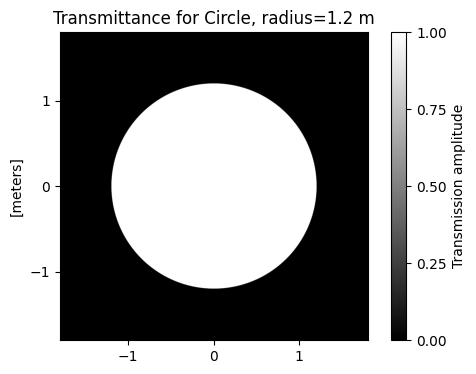

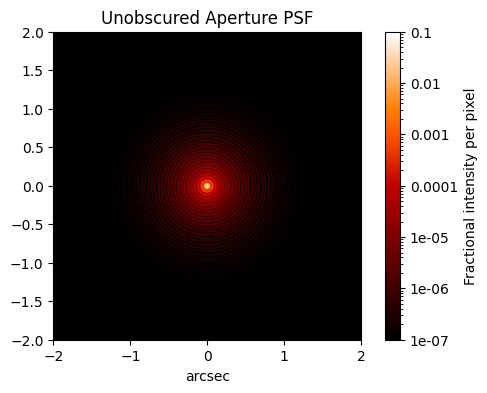

In [29]:
diam = 2.4 * u.m
epsilon = 0.3  # obscuration diameter fraction
pixelscale = 0.02  # set for HST diameters
fov_arcsec = 4.0
wavelength = 0.5e-6  # visible default unit in m
oversample = 2

# Make unobscured aperture
osys_unobsc = poppy.OpticalSystem("test", oversample=oversample)
pupil_unobsc = poppy.CircularAperture(radius=diam.value / 2.0)

osys_unobsc.add_pupil(pupil_unobsc)  # pupil radius in meters
# image plane coordinates in arcseconds
osys_unobsc.add_detector(pixelscale=pixelscale, fov_arcsec=fov_arcsec)
plt.figure(figsize=(6, 4))
pupil_unobsc.display(npix=1024, colorbar_orientation="vertical")
plt.show()

psf_unobsc = osys_unobsc.calc_psf(wavelength)  # wavelength in microns
plt.figure(figsize=(6, 4))
poppy.display_psf(psf_unobsc, title="Unobscured Aperture PSF")
plt.show()

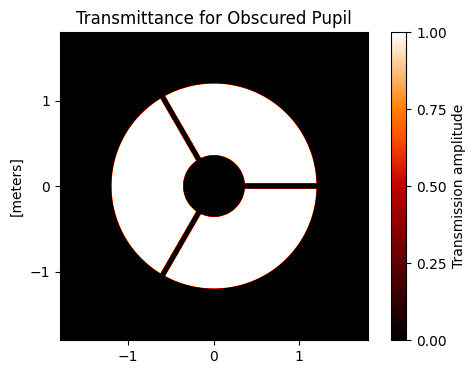

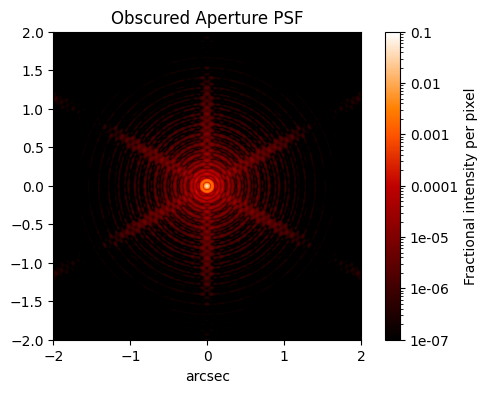

In [30]:
# Make a compound obscured aperture
pupil_ap = poppy.CircularAperture(radius=diam.value / 2.0)
# add secondary obscuration with spider.  Make support width 1/40th diameter
pupil_sec = poppy.SecondaryObscuration(
    secondary_radius=epsilon * diam.value / 2.0,
    n_supports=3,
    support_width=diam.value / 40.0,
)

# add together the the aparteure and the secondary obsucation
pupil_obsc = poppy.CompoundAnalyticOptic(
    opticslist=[pupil_ap, pupil_sec], name="Obscured Pupil"
)  # combine into one optic

plt.figure(figsize=(6, 4))
pupil_obsc.display(npix=1024, colorbar_orientation="vertical")
plt.show()

osys_obsc = poppy.OpticalSystem()
osys_obsc.add_pupil(pupil_obsc)
osys_obsc.add_detector(pixelscale=pixelscale, fov_arcsec=fov_arcsec)
psf_obsc = osys_obsc.calc_psf(wavelength)

plt.figure(figsize=(6, 4))
poppy.display_psf(psf_obsc, title="Obscured Aperture PSF")
plt.show()

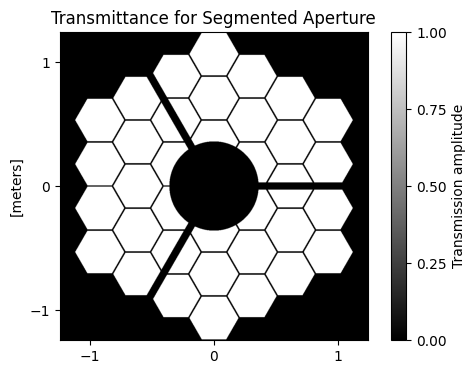

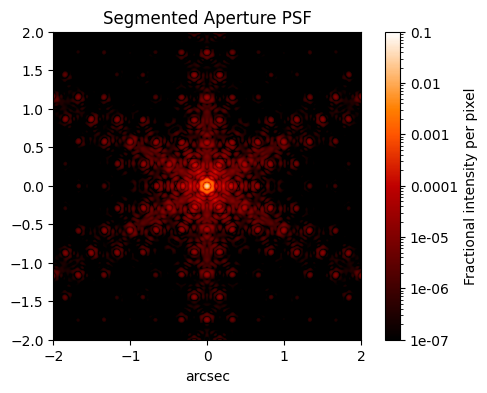

In [31]:
pupil_seg_ap = poppy.MultiHexagonAperture(
    rings=3, flattoflat=diam.value / 7, gap=diam.value / 200
)  # approx circumscribed diameter
pupil_seg_sec = poppy.SecondaryObscuration(
    secondary_radius=epsilon * diam.value / 2,
    n_supports=3,
    support_width=diam.value / 40,
)  # secondary with spiders
pupil_seg = poppy.CompoundAnalyticOptic(
    opticslist=[pupil_seg_ap, pupil_seg_sec], name="Segmented Aperture"
)  # combine into one optic

# now design an optical system
osys_seg = poppy.OpticalSystem()
osys_seg.add_pupil(pupil_seg)
osys_seg.add_detector(pixelscale=pixelscale, fov_arcsec=fov_arcsec)
psf_seg = osys_seg.calc_psf(wavelength)

plt.figure(figsize=(6, 4))
pupil_seg.display(npix=1024, colorbar_orientation="vertical")
plt.show()


plt.figure(figsize=(6, 4))
poppy.display_psf(psf_seg, title="Segmented Aperture PSF")
plt.show()

Calculate the radial profile for the above PSFs (start with 2.4m example, but then switch to 100m)



*   Show 1-D radial profile (with radius in arcseconds) for all PSFs
*   Compare with theoretical Airy Function (for different obscurations) and predicted location of first minima
*    Make an additional set of plots showing the encircled energy vs. radius (using POPPY utility code)





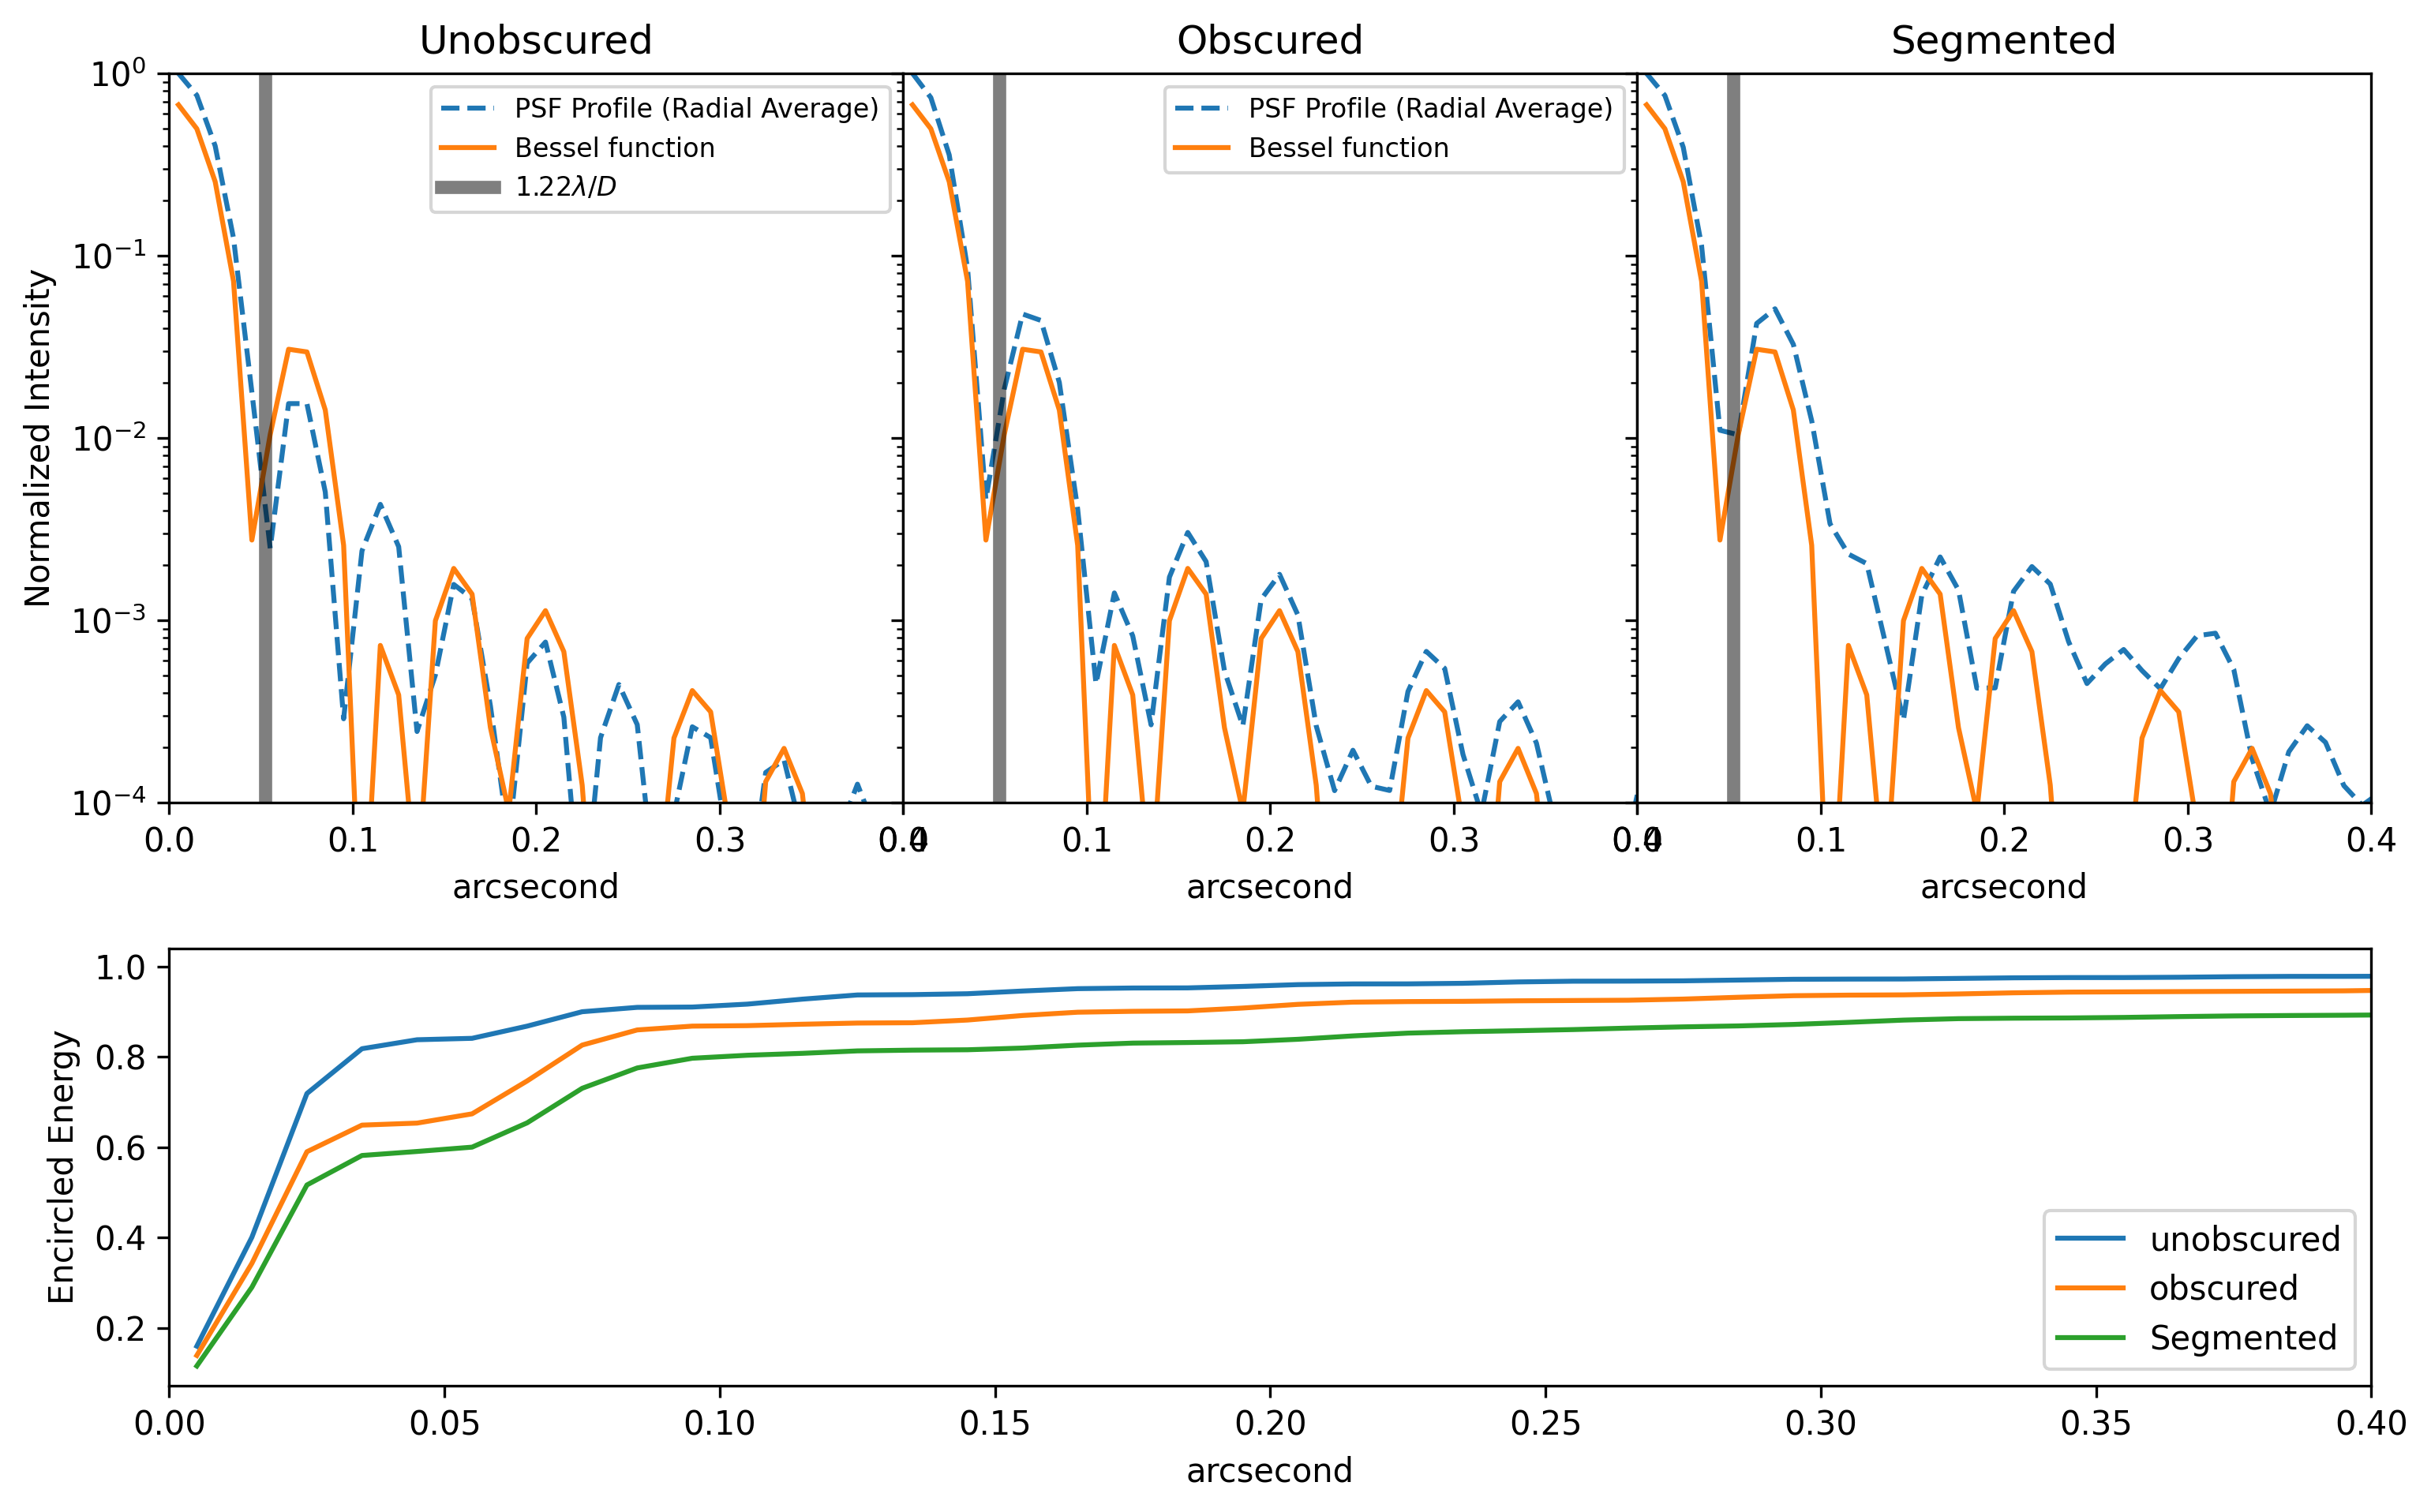

In [16]:
airy_profile_unobsc = poppy.utils.radial_profile(psf_unobsc, ee=True)
airy_profile_obsc = poppy.utils.radial_profile(psf_obsc, ee=True)
airy_profile_seg = poppy.utils.radial_profile(psf_seg, ee=True)

rayleigh_criterion = 1.22 * wavelength / diam.value * (180.0 * 3600 / np.pi)

# Defive v as:
v_unobsc = airy_profile_unobsc[0] * np.pi / (rayleigh_criterion / 1.22)
v_obsc = airy_profile_obsc[0] * np.pi / (rayleigh_criterion / 1.22)
v_segmented = airy_profile_seg[0] * np.pi / (rayleigh_criterion / 1.22)
# Show theoretical Airy Profile (Using Bessel Function formula for ip)

ip_unobsc = (1 / (1 + epsilon**2)) ** 2 * (
    (2 * jv(1, v_unobsc) / v_unobsc)
    - epsilon**2 * (2 * jv(1, epsilon * v_unobsc) / (epsilon * v_unobsc))
) ** 2
ip_obsc = (1 / (1 + epsilon**2)) ** 2 * (
    (2 * jv(1, v_obsc) / v_obsc)
    - epsilon**2 * (2 * jv(1, epsilon * v_obsc) / (epsilon * v_obsc))
) ** 2
ip_segmented = (1 / (1 + epsilon**2)) ** 2 * (
    (2 * jv(1, v_segmented) / v_segmented)
    - epsilon**2 * (2 * jv(1, epsilon * v_segmented) / (epsilon * v_segmented))
) ** 2

# plot radial averages:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), dpi=300, sharex=True, sharey=True)
fig.subplots_adjust(wspace=0, hspace=0)
ax[0].plot(
    airy_profile_unobsc[0],
    airy_profile_unobsc[1] / airy_profile_unobsc[1].max(),
    "--",
    label="PSF Profile (Radial Average)",
)
ax[0].plot(airy_profile_unobsc[0], ip_unobsc, "-", label="Bessel function")
ax[0].axvline(rayleigh_criterion, lw=4, color="k", alpha=0.5, label="$1.22\lambda/D$")

# Add obscured profile
ax[1].plot(
    airy_profile_obsc[0],
    airy_profile_obsc[1] / airy_profile_obsc[1].max(),
    "--",
    label="PSF Profile (Radial Average)",
)
ax[1].plot(airy_profile_obsc[0], ip_obsc, "-", label="Bessel function")
ax[1].axvline(rayleigh_criterion, lw=4, color="k", alpha=0.5)

# Add segmented profile
ax[2].plot(
    airy_profile_seg[0],
    airy_profile_seg[1] / airy_profile_seg[1].max(),
    "--",
    label="PSF Profile (Radial Average)",
)
ax[2].plot(airy_profile_seg[0], ip_segmented, "-", label="Bessel function")
ax[2].axvline(rayleigh_criterion, lw=4, color="k", alpha=0.5)


ax[0].set(
    yscale="log",
    xlim=(0, 0.4),
    ylim=(1e-4, 1),
    ylabel="Normalized Intensity",
    xlabel="arcsecond",
    title="Unobscured",
)
ax[1].set(title="Obscured", xlabel="arcsecond")
ax[2].set(title="Segmented", xlabel="arcsecond")

ax[0].legend(fontsize=8)
ax[1].legend(fontsize=8)

ee_ax = ax[0].inset_axes([0, -0.8, 3, 0.6])
ee_ax.plot(airy_profile_unobsc[0], airy_profile_unobsc[2], label="unobscured")
ee_ax.plot(airy_profile_obsc[0], airy_profile_obsc[2], label="obscured")
ee_ax.plot(airy_profile_seg[0], airy_profile_seg[2], label="Segmented")
ee_ax.set(xlim=(0, 0.4), xlabel="arcsecond", ylabel="Encircled Energy")
ee_ax.legend()
plt.show()

## 100 Meter

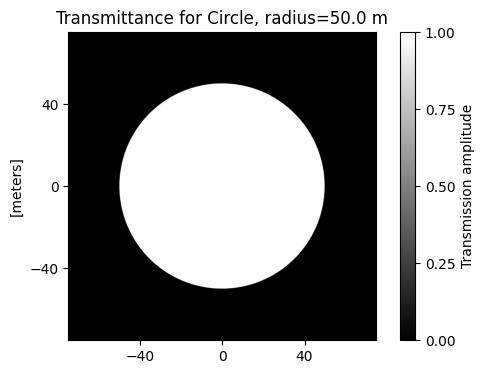

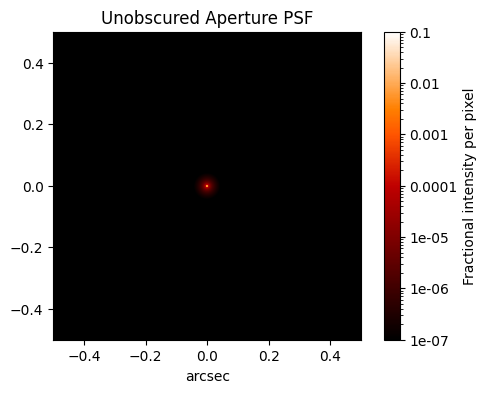

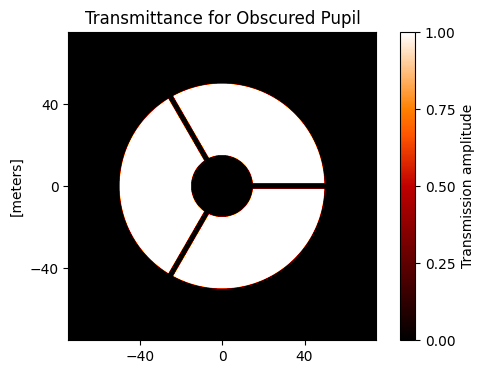

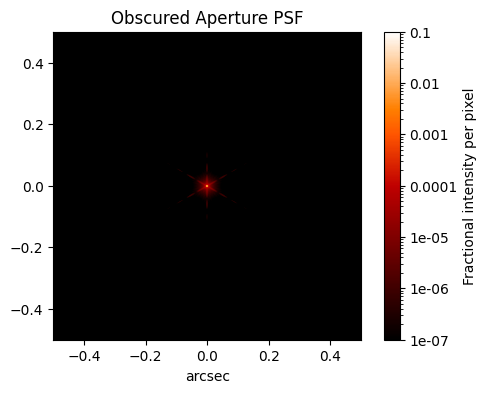

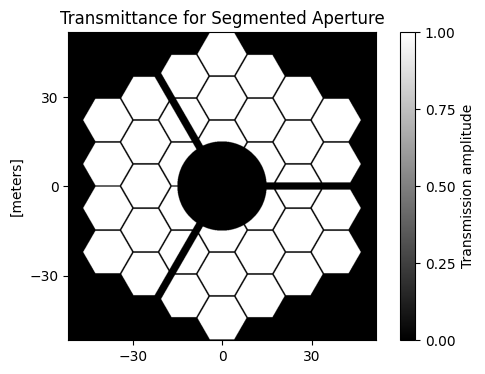

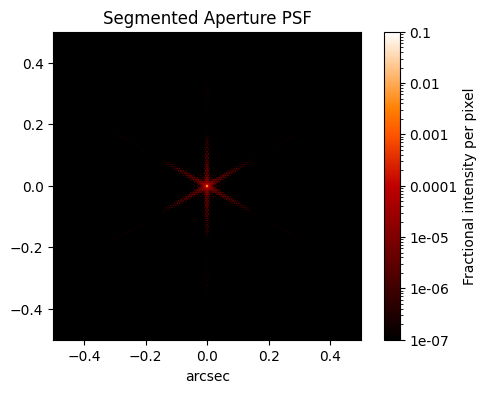

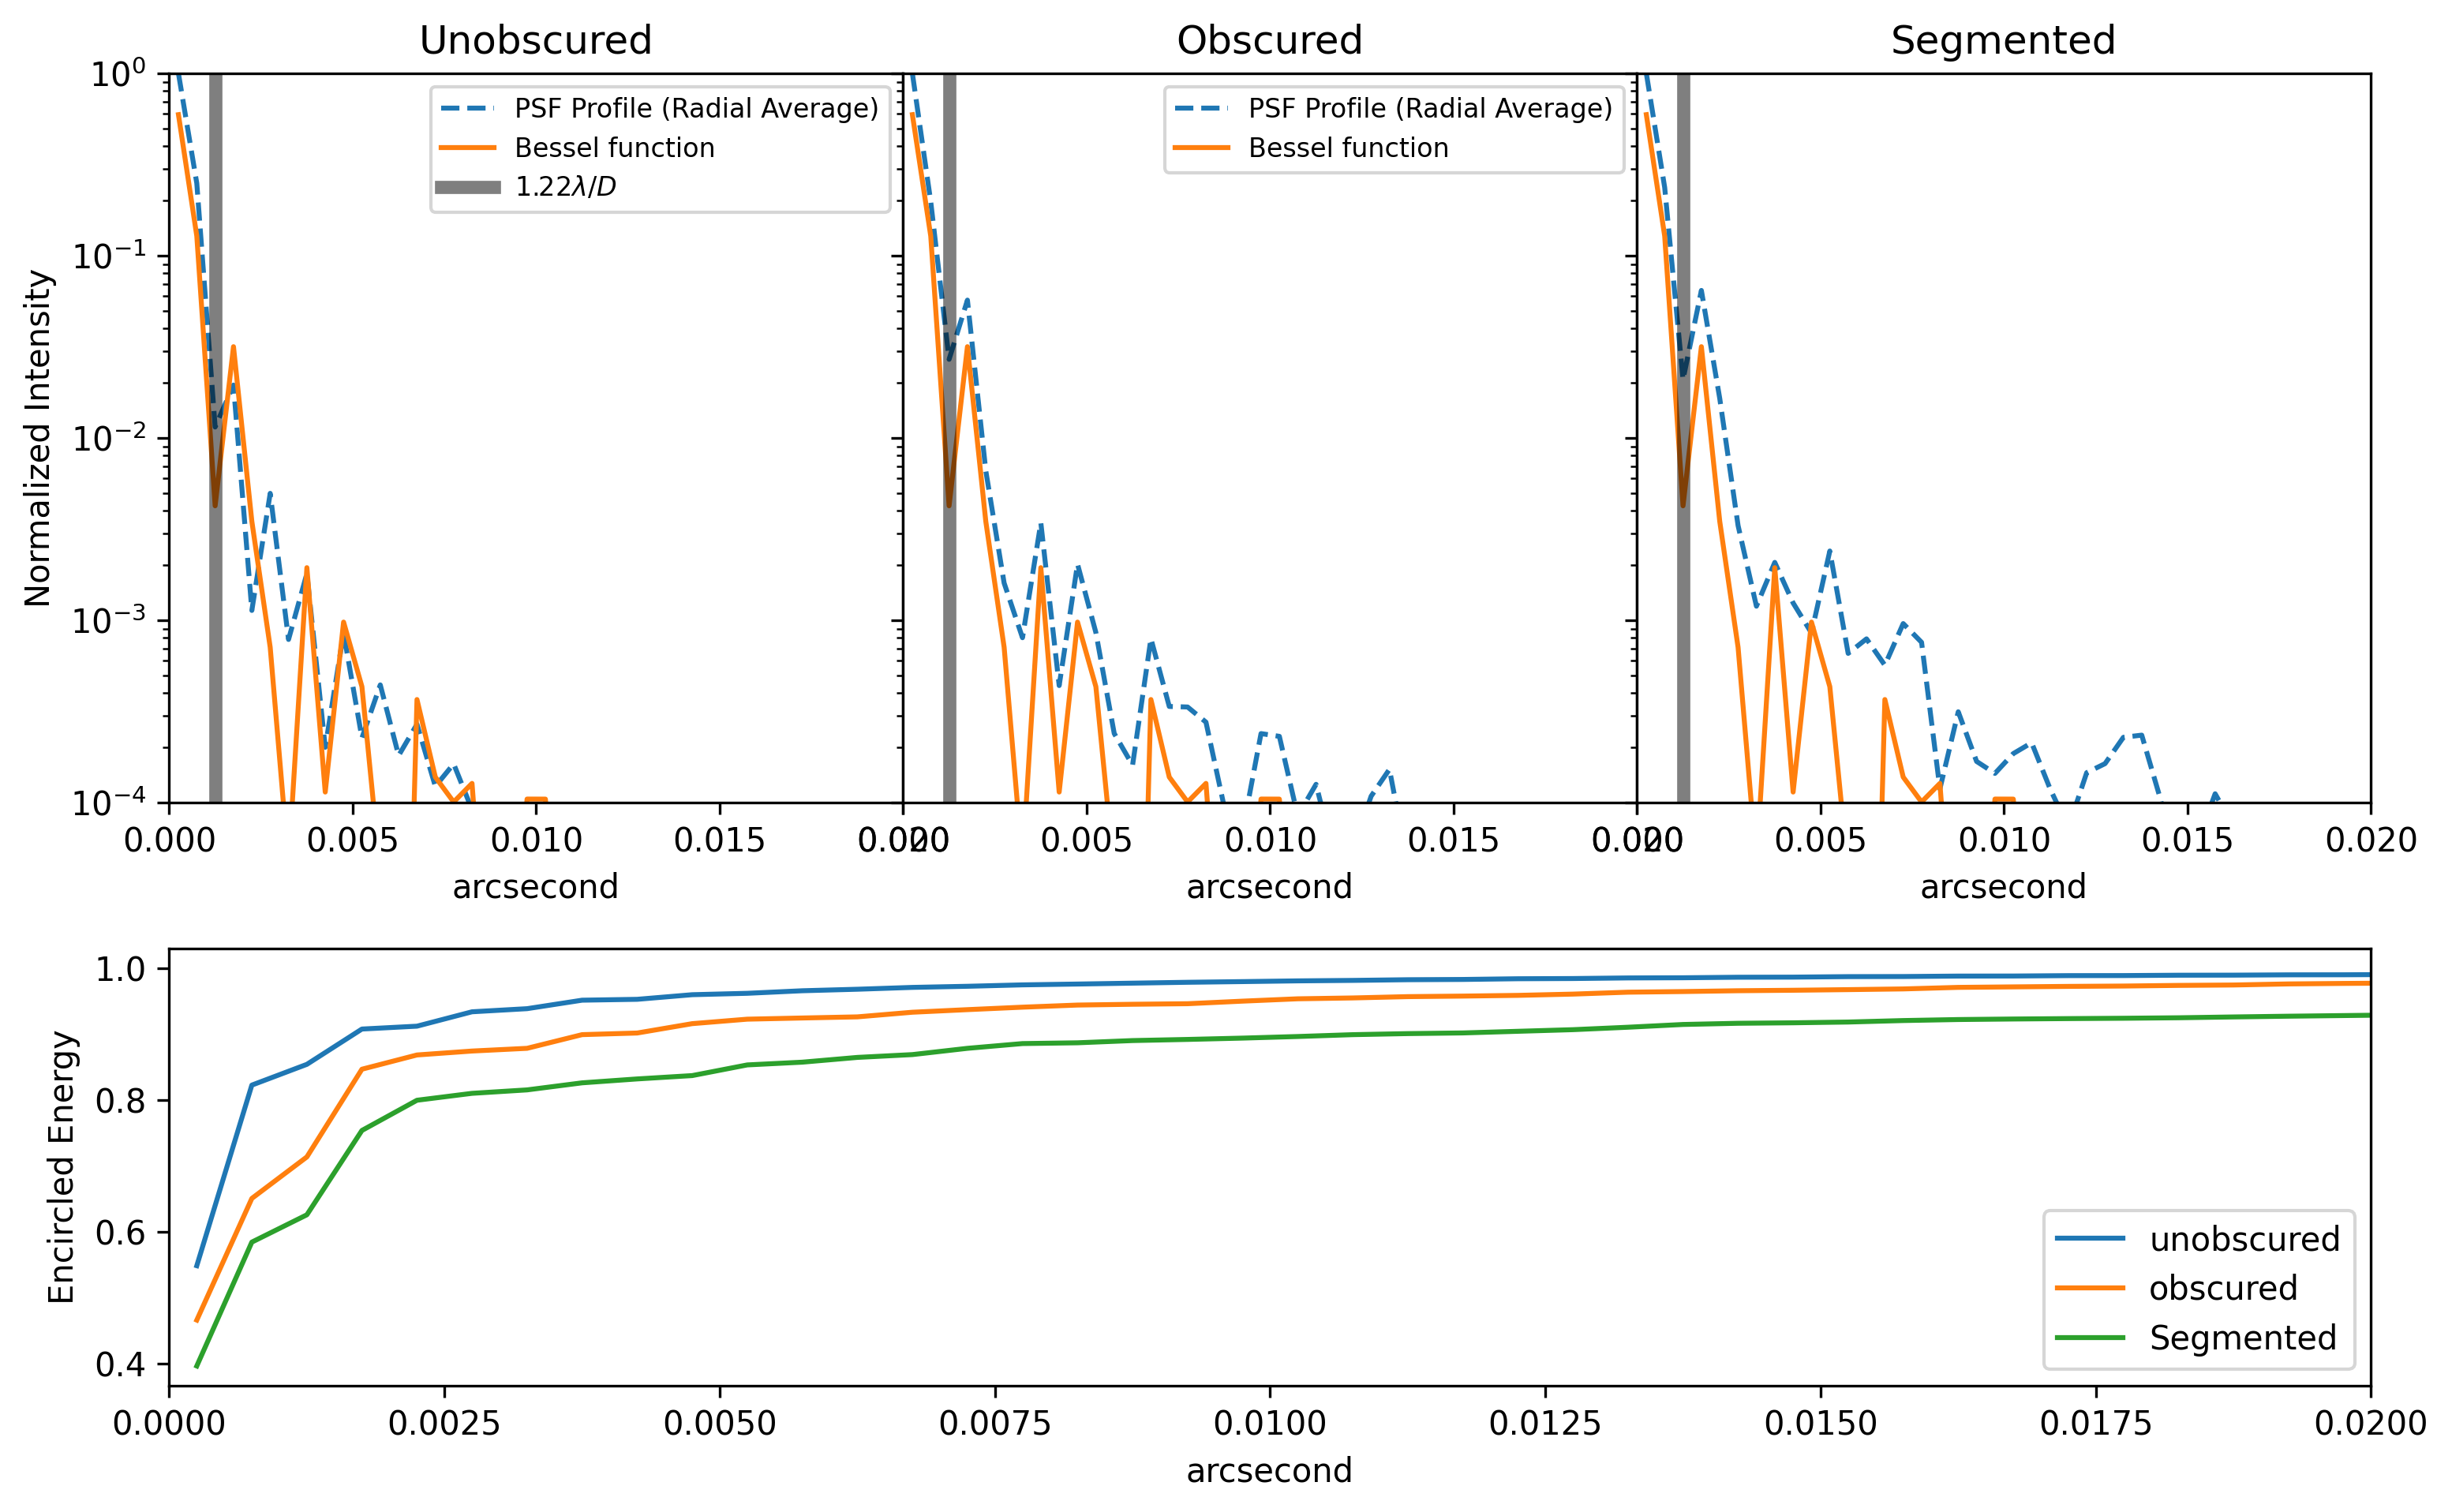

In [24]:
diam = 100 * u.m
epsilon = 0.3  # obscuration diameter fraction
pixelscale = 0.001
fov_arcsec = 1
wavelength = 0.5e-6  # visible default unit in m
oversample = 2

# Make unobscured aperture
osys_unobsc = poppy.OpticalSystem("test", oversample=oversample)
pupil_unobsc = poppy.CircularAperture(radius=diam.value / 2.0)

osys_unobsc.add_pupil(pupil_unobsc)  # pupil radius in meters
# image plane coordinates in arcseconds
osys_unobsc.add_detector(pixelscale=pixelscale, fov_arcsec=fov_arcsec)
plt.figure(figsize=(6, 4))
pupil_unobsc.display(npix=1024, colorbar_orientation="vertical")
plt.show()

psf_unobsc = osys_unobsc.calc_psf(wavelength)  # wavelength in microns
plt.figure(figsize=(6, 4))
poppy.display_psf(psf_unobsc, title="Unobscured Aperture PSF")
plt.show()


# Make a compound obscured aperture
pupil_ap = poppy.CircularAperture(radius=diam.value / 2.0)
# add secondary obscuration with spider.  Make support width 1/40th diameter
pupil_sec = poppy.SecondaryObscuration(
    secondary_radius=epsilon * diam.value / 2.0,
    n_supports=3,
    support_width=diam.value / 40.0,
)

# add together the the aparteure and the secondary obsucation
pupil_obsc = poppy.CompoundAnalyticOptic(
    opticslist=[pupil_ap, pupil_sec], name="Obscured Pupil"
)  # combine into one optic

plt.figure(figsize=(6, 4))
pupil_obsc.display(npix=1024, colorbar_orientation="vertical")
plt.show()

osys_obsc = poppy.OpticalSystem()
osys_obsc.add_pupil(pupil_obsc)
osys_obsc.add_detector(pixelscale=pixelscale, fov_arcsec=fov_arcsec)
psf_obsc = osys_obsc.calc_psf(wavelength)

plt.figure(figsize=(6, 4))
poppy.display_psf(psf_obsc, title="Obscured Aperture PSF")
plt.show()

pupil_seg_ap = poppy.MultiHexagonAperture(
    rings=3, flattoflat=diam.value / 7, gap=diam.value / 200
)  # approx circumscribed diameter
pupil_seg_sec = poppy.SecondaryObscuration(
    secondary_radius=epsilon * diam.value / 2,
    n_supports=3,
    support_width=diam.value / 40,
)  # secondary with spiders
pupil_seg = poppy.CompoundAnalyticOptic(
    opticslist=[pupil_seg_ap, pupil_seg_sec], name="Segmented Aperture"
)  # combine into one optic

# now design an optical system
osys_seg = poppy.OpticalSystem()
osys_seg.add_pupil(pupil_seg)
osys_seg.add_detector(pixelscale=pixelscale, fov_arcsec=fov_arcsec)
psf_seg = osys_seg.calc_psf(wavelength)

plt.figure(figsize=(6, 4))
pupil_seg.display(npix=1024, colorbar_orientation="vertical")
plt.show()


plt.figure(figsize=(6, 4))
poppy.display_psf(psf_seg, title="Segmented Aperture PSF")
plt.show()

airy_profile_unobsc = poppy.utils.radial_profile(psf_unobsc, ee=True)
airy_profile_obsc = poppy.utils.radial_profile(psf_obsc, ee=True)
airy_profile_seg = poppy.utils.radial_profile(psf_seg, ee=True)

rayleigh_criterion = 1.22 * wavelength / diam.value * (180.0 * 3600 / np.pi)

# Defive v as:
v_unobsc = airy_profile_unobsc[0] * np.pi / (rayleigh_criterion / 1.22)
v_obsc = airy_profile_obsc[0] * np.pi / (rayleigh_criterion / 1.22)
v_segmented = airy_profile_seg[0] * np.pi / (rayleigh_criterion / 1.22)
# Show theoretical Airy Profile (Using Bessel Function formula for ip)

ip_unobsc = (1 / (1 + epsilon**2)) ** 2 * (
    (2 * jv(1, v_unobsc) / v_unobsc)
    - epsilon**2 * (2 * jv(1, epsilon * v_unobsc) / (epsilon * v_unobsc))
) ** 2
ip_obsc = (1 / (1 + epsilon**2)) ** 2 * (
    (2 * jv(1, v_obsc) / v_obsc)
    - epsilon**2 * (2 * jv(1, epsilon * v_obsc) / (epsilon * v_obsc))
) ** 2
ip_segmented = (1 / (1 + epsilon**2)) ** 2 * (
    (2 * jv(1, v_segmented) / v_segmented)
    - epsilon**2 * (2 * jv(1, epsilon * v_segmented) / (epsilon * v_segmented))
) ** 2

# plot radial averages:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), dpi=300, sharex=True, sharey=True)
fig.subplots_adjust(wspace=0, hspace=0)
ax[0].plot(
    airy_profile_unobsc[0],
    airy_profile_unobsc[1] / airy_profile_unobsc[1].max(),
    "--",
    label="PSF Profile (Radial Average)",
)
ax[0].plot(airy_profile_unobsc[0], ip_unobsc, "-", label="Bessel function")
ax[0].axvline(rayleigh_criterion, lw=4, color="k", alpha=0.5, label="$1.22\lambda/D$")

# Add obscured profile
ax[1].plot(
    airy_profile_obsc[0],
    airy_profile_obsc[1] / airy_profile_obsc[1].max(),
    "--",
    label="PSF Profile (Radial Average)",
)
ax[1].plot(airy_profile_obsc[0], ip_obsc, "-", label="Bessel function")
ax[1].axvline(rayleigh_criterion, lw=4, color="k", alpha=0.5)

# Add segmented profile
ax[2].plot(
    airy_profile_seg[0],
    airy_profile_seg[1] / airy_profile_seg[1].max(),
    "--",
    label="PSF Profile (Radial Average)",
)
ax[2].plot(airy_profile_seg[0], ip_segmented, "-", label="Bessel function")
ax[2].axvline(rayleigh_criterion, lw=4, color="k", alpha=0.5)


ax[0].set(
    yscale="log",
    xlim=(0, 0.02),
    ylim=(1e-4, 1),
    ylabel="Normalized Intensity",
    xlabel="arcsecond",
    title="Unobscured",
)
ax[1].set(title="Obscured", xlabel="arcsecond")
ax[2].set(title="Segmented", xlabel="arcsecond")

ax[0].legend(fontsize=8)
ax[1].legend(fontsize=8)

ee_ax = ax[0].inset_axes([0, -0.8, 3, 0.6])
ee_ax.plot(airy_profile_unobsc[0], airy_profile_unobsc[2], label="unobscured")
ee_ax.plot(airy_profile_obsc[0], airy_profile_obsc[2], label="obscured")
ee_ax.plot(airy_profile_seg[0], airy_profile_seg[2], label="Segmented")
ee_ax.set(xlim=(0, 0.02), xlabel="arcsecond", ylabel="Encircled Energy")
ee_ax.legend()
plt.show()

# Image Simulator

Lastly, we will build an initial image simulator, assuming that we observe a point source with the PSFs calculated above

Key inputs are:

*   Point source magnitude
*   Telescope parameters (Aeff, dlambda, texp)
*   Sky background in magnitudes / arcsec^2
*   Pupil (from POPPY)
*   Assumed pixelscale and field-of-view (in arcseconds)
*   Assumed wavelength for calculating PSF

To perform this calculation you will complete the below function by calculating:

*   PSF Mean expected counts per pixel, given a normalized PSF and an estimate of the total counts expected for the source during an exposure
*   Sky background mean counts per pixel, based on sky brightness
*   Using combined PSF Mean + Sky Mean image, simulate counts assuming they follow a Poisson distribution, with given mean






### comments from David
Backgroound is mag/arcsec^2
CTS = (flux * effective area * deltaLambda * time / arcsec^2) * (pixelscale)^2

I think changing it to counts per pixel instead of counts per arcsec^2 because its a bit more intuitive, since the telescope can have varying arcsec fov? Or is doing it per arcsec^2 allow for better comparison between systems?

Total num photons from sky 299.5435761276629
Sky background mean photons per pixel 0.011700920942486835
Sky background mean counts per arcsec^2 18.72147350797893
source photon flux 1.3926e-09
source photon per arcsec^2 0.011812451209350691
source total # photons 0.18899921934961106


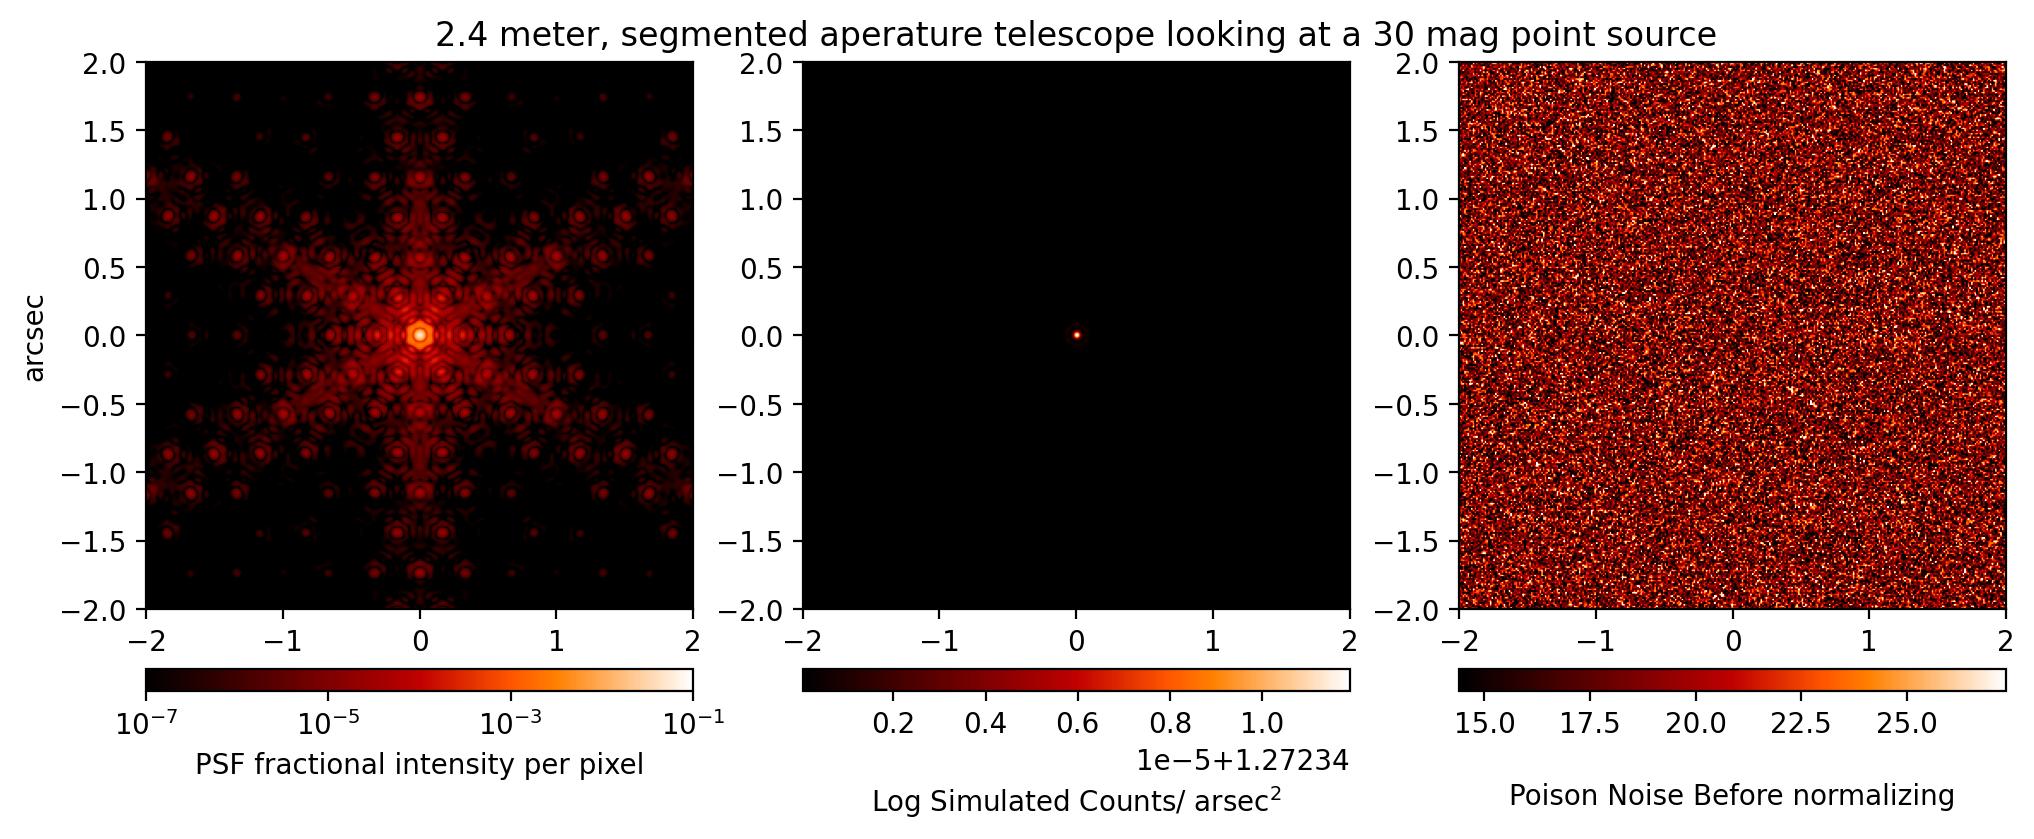

In [96]:
def image_simulator(
    mag,
    aeff,
    dlambda,
    texp,
    sky_mag_asec2,
    pupil,
    pixelscale,
    fov_arcsec,
    wavelength,
    title,
):
    """_summary_

    Args:
        mag (float): magnitude of observed object
        aeff (float): effective area of the telescope, accounting for obscuration
        dlambda (float): passband of the telescope
        texp (float): exposure time
        sky_mag_asec2 (float): uniform background magnitude of the sky
        pupil (float): pupil design, which will be combined with the optical system
        pixelscale (float): pixel scale in arcsec/ pixel
        fov_arcsec (float): field of view area is fov_arcsec^2
        wavelength (float): the central wavelength to observe

    Returns:
        float: _description_
    """
    osys_tmp = poppy.OpticalSystem()
    osys_tmp.add_pupil(pupil)
    osys_tmp.add_detector(pixelscale=pixelscale, fov_arcsec=fov_arcsec)
    psf_tmp = osys_tmp.calc_psf(wavelength)
    fractional_intensity_per_pixel = psf_tmp[0].data

    Phi_zero_point = 1392.6 * (u.cm**-2 * u.s**-1 * u.Angstrom**-1)

    # has units of  photons / cm^2 / s/ Angstrom
    source_photon_flux = Phi_zero_point.value * 10 ** -(0.4 * mag)

    # has units of  photons / cm^2 / s/ Angstrom
    background_flux_per_arsec2 = Phi_zero_point.value * 10 ** -(0.4 * sky_mag_asec2)
    background_number_of_photos = background_flux_per_arsec2 * aeff * dlambda * texp
    # total number of photons from sky background / arcsec^2
    # has units of # photons from sky per arcsec^2
    sky_mean_cts = (background_flux_per_arsec2 * aeff * dlambda * texp) / fov_arcsec**2
    sky_photons_per_pix = sky_mean_cts * pixelscale**2
    print("Total num photons from sky", background_number_of_photos)
    print("Sky background mean photons per pixel", sky_photons_per_pix)
    print("Sky background mean counts per arcsec^2", sky_mean_cts)

    total_photons_hitting_detector = source_photon_flux * aeff * dlambda * texp
    source_photons_per_arcsec2 = total_photons_hitting_detector / fov_arcsec**2
    psf_sim_mean_cts = fractional_intensity_per_pixel * source_photons_per_arcsec2
    # psf_sim_mean_cts = fractional_intensity_per_pixel * total_photons_hitting_detector
    # we'll do count per pixel
    #  print(psf_sim_mean_cts)
    # (photons /arcsec^2) * (arcsec**2 / pixel**2) = phtons/pixel
    psf_sim_counts_per_pix = psf_sim_mean_cts * pixelscale**2

    print("source photon flux", source_photon_flux)
    print("source photon per arcsec^2", source_photons_per_arcsec2)
    print("source total # photons", total_photons_hitting_detector)

    # matrix of sky background
    sky_im_mean = np.zeros(psf_sim_mean_cts.shape) + sky_mean_cts
    psf_sim_mean_cts = psf_sim_mean_cts + sky_im_mean
    im_sim_poisson = np.random.poisson(psf_sim_mean_cts)

    immean = np.mean(im_sim_poisson)
    imstd = np.std(im_sim_poisson)

    fig, ax = plt.subplots(1, 3, figsize=(12, 4), dpi=200)
    psfcbar_ax = ax[0].inset_axes([0, -0.15, 1, 0.04])
    cbar_ax = ax[1].inset_axes([0, -0.15, 1, 0.04])
    poisson_cbar_ax = ax[2].inset_axes([0, -0.15, 1, 0.04])

    extent = [-fov_arcsec / 2, fov_arcsec / 2, -fov_arcsec / 2, fov_arcsec / 2]
    psf_image = ax[0].imshow(
        fractional_intensity_per_pixel,
        norm=LogNorm(1e-7, 0.1),
        cmap="gist_heat",
        origin="lower",
        extent=extent,
    )
    sim_image = ax[1].imshow(
        np.log10(psf_sim_mean_cts), cmap="gist_heat", origin="lower", extent=extent
    )
    skyim = ax[2].imshow(
        im_sim_poisson,
        cmap="gist_heat",
        vmin=immean - imstd,
        vmax=immean + 2 * imstd,
        origin="lower",
        extent=extent,
    )

    psf_cbar = fig.colorbar(
        psf_image,
        cax=psfcbar_ax,
        pad=0,
        orientation="horizontal",
        label="PSF fractional intensity per pixel",
    )
    cbar = fig.colorbar(
        sim_image,
        cax=cbar_ax,
        pad=0,
        orientation="horizontal",
        label="\n" "Log" " Simulated Counts" r"/ arsec$^2$",
    )
    poisson_cbar = fig.colorbar(
        skyim,
        cax=poisson_cbar_ax,
        pad=0,
        orientation="horizontal",
        label="\n" "Poison Noise Before normalizing",
    )
    ax[0].set(ylabel="arcsec")

    ax[1].set(title=title)

    return psf_sim_mean_cts, im_sim_poisson


epsilon = 0.3
radius = 120.0 * u.cm  # cm
diam = 2 * radius.to(u.m)
mag = 30
aeff = epsilon * np.pi * (diam.value / 2) ** 2  # m2

dlambda = 1000.0  # Angstrom
texp = 1e5
sky_mag_asec2 = 22.0
pixelscale = 0.025
fov_arcsec = 4.0  # fov on one side, so a 1x1 arcsec fov
wavelength = 0.5e-6

pupil_seg_ap = poppy.MultiHexagonAperture(
    rings=3, flattoflat=diam.value / 7, gap=diam.value / 200
)  # approx circumscribed diameter
pupil_seg_sec = poppy.SecondaryObscuration(
    secondary_radius=epsilon * diam.value / 2,
    n_supports=3,
    support_width=diam.value / 40,
)  # secondary with spiders
pupil_seg = poppy.CompoundAnalyticOptic(
    opticslist=[pupil_seg_ap, pupil_seg_sec], name="Segmented Aperture"
)  # combine into one optic

pupil = pupil_seg

im_sim, im_sim_poisson = image_simulator(
    mag,
    aeff,
    dlambda,
    texp,
    sky_mag_asec2,
    pupil,
    pixelscale,
    fov_arcsec,
    wavelength,
    title="2.4 meter, segmented aperature telescope looking at a 30 mag point source",
)
plt.show()

Total num photons from sky 2080163.7231087699
Sky background mean photons per pixel 832.0654892435078
Sky background mean counts per arcsec^2 20801637231.087696
source photon flux 1.3926e-09
source photon per arcsec^2 13124945.788167436
source total # photons 1312.4945788167436


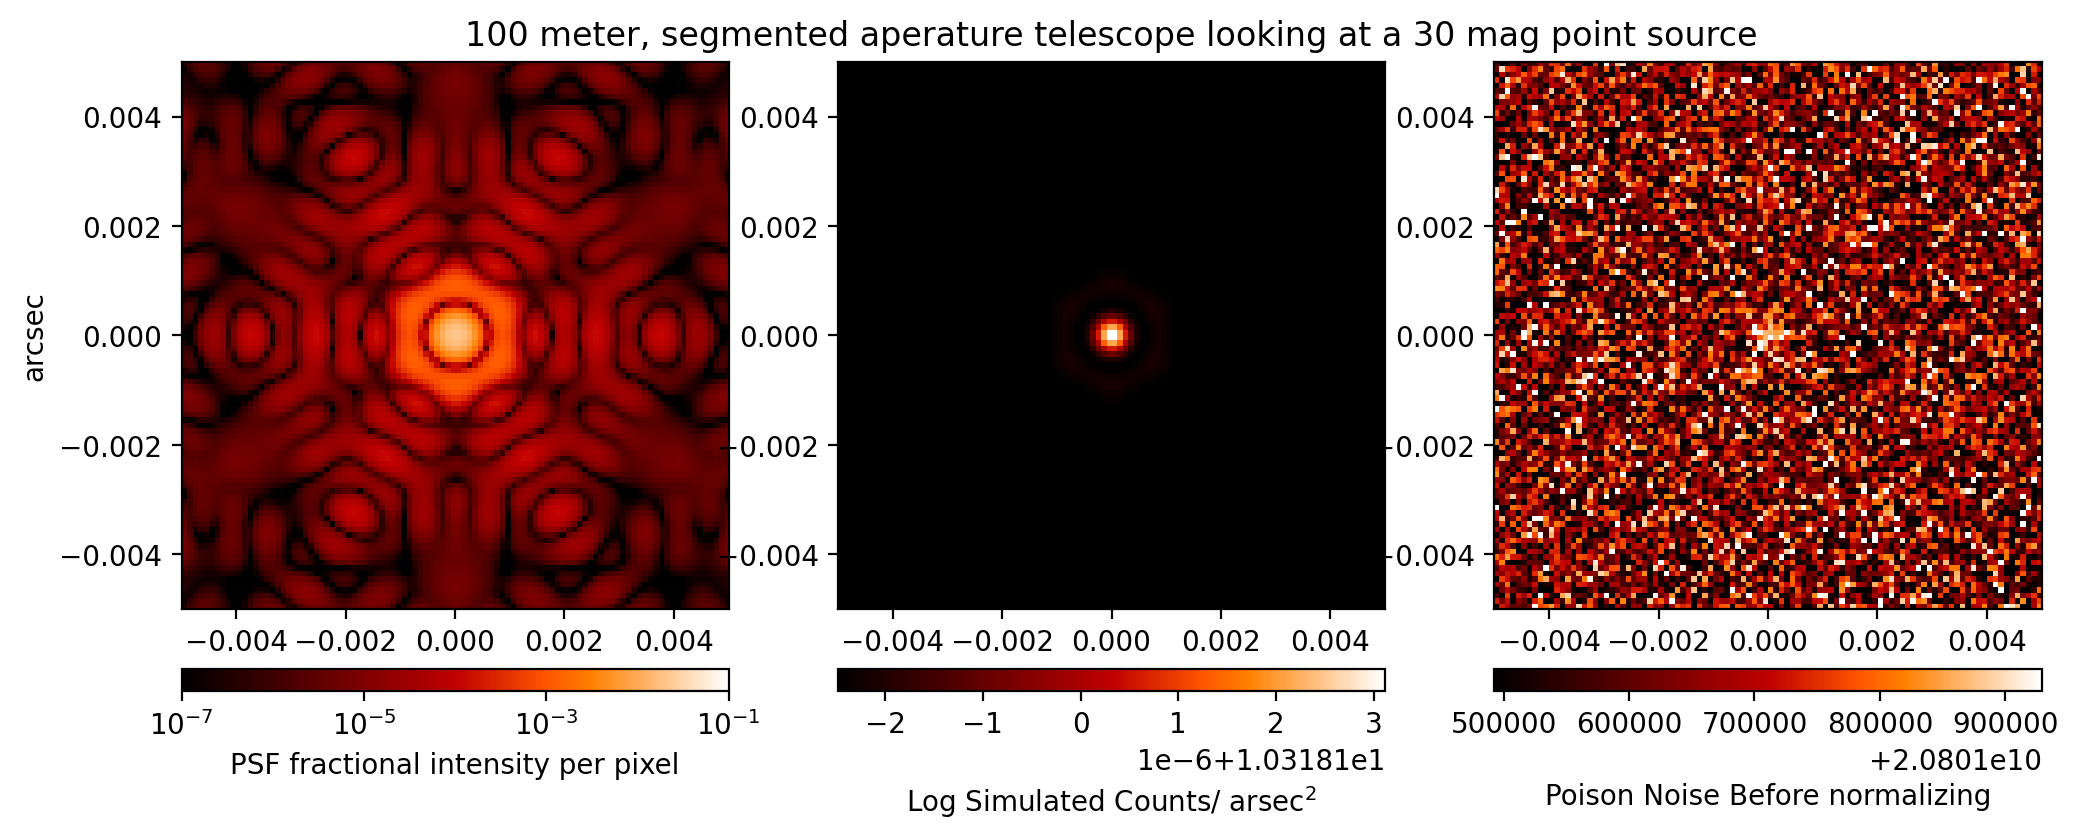

In [97]:
epsilon = 0.3
radius = 1e4 * u.cm  # cm
diam = 2 * radius.to(u.m)
mag = 30
aeff = epsilon * np.pi * (diam.value / 2) ** 2  # m2

dlambda = 1000.0  # Angstrom
texp = 1e5
sky_mag_asec2 = 22.0
pixelscale = 0.0002
fov_arcsec = 0.01  # fov on one side, so a 1x1 arcsec fov
wavelength = 0.5e-6

pupil_seg_ap = poppy.MultiHexagonAperture(
    rings=3, flattoflat=diam.value / 7, gap=diam.value / 200
)  # approx circumscribed diameter
pupil_seg_sec = poppy.SecondaryObscuration(
    secondary_radius=epsilon * diam.value / 2,
    n_supports=3,
    support_width=diam.value / 40,
)  # secondary with spiders
pupil_seg = poppy.CompoundAnalyticOptic(
    opticslist=[pupil_seg_ap, pupil_seg_sec], name="Segmented Aperture"
)  # combine into one optic

pupil = pupil_seg

im_sim, im_sim_poisson = image_simulator(
    mag,
    aeff,
    dlambda,
    texp,
    sky_mag_asec2,
    pupil,
    pixelscale,
    fov_arcsec,
    wavelength,
    title="100 meter, segmented aperature telescope looking at a 30 mag point source",
)
plt.show()

Total num photons from sky 520040.93077719247
Sky background mean photons per pixel 208.01637231087696
Sky background mean counts per arcsec^2 5200409307.771924
source photon flux 1.3926e-09
source photon per arcsec^2 3281236.447041859
source total # photons 328.1236447041859


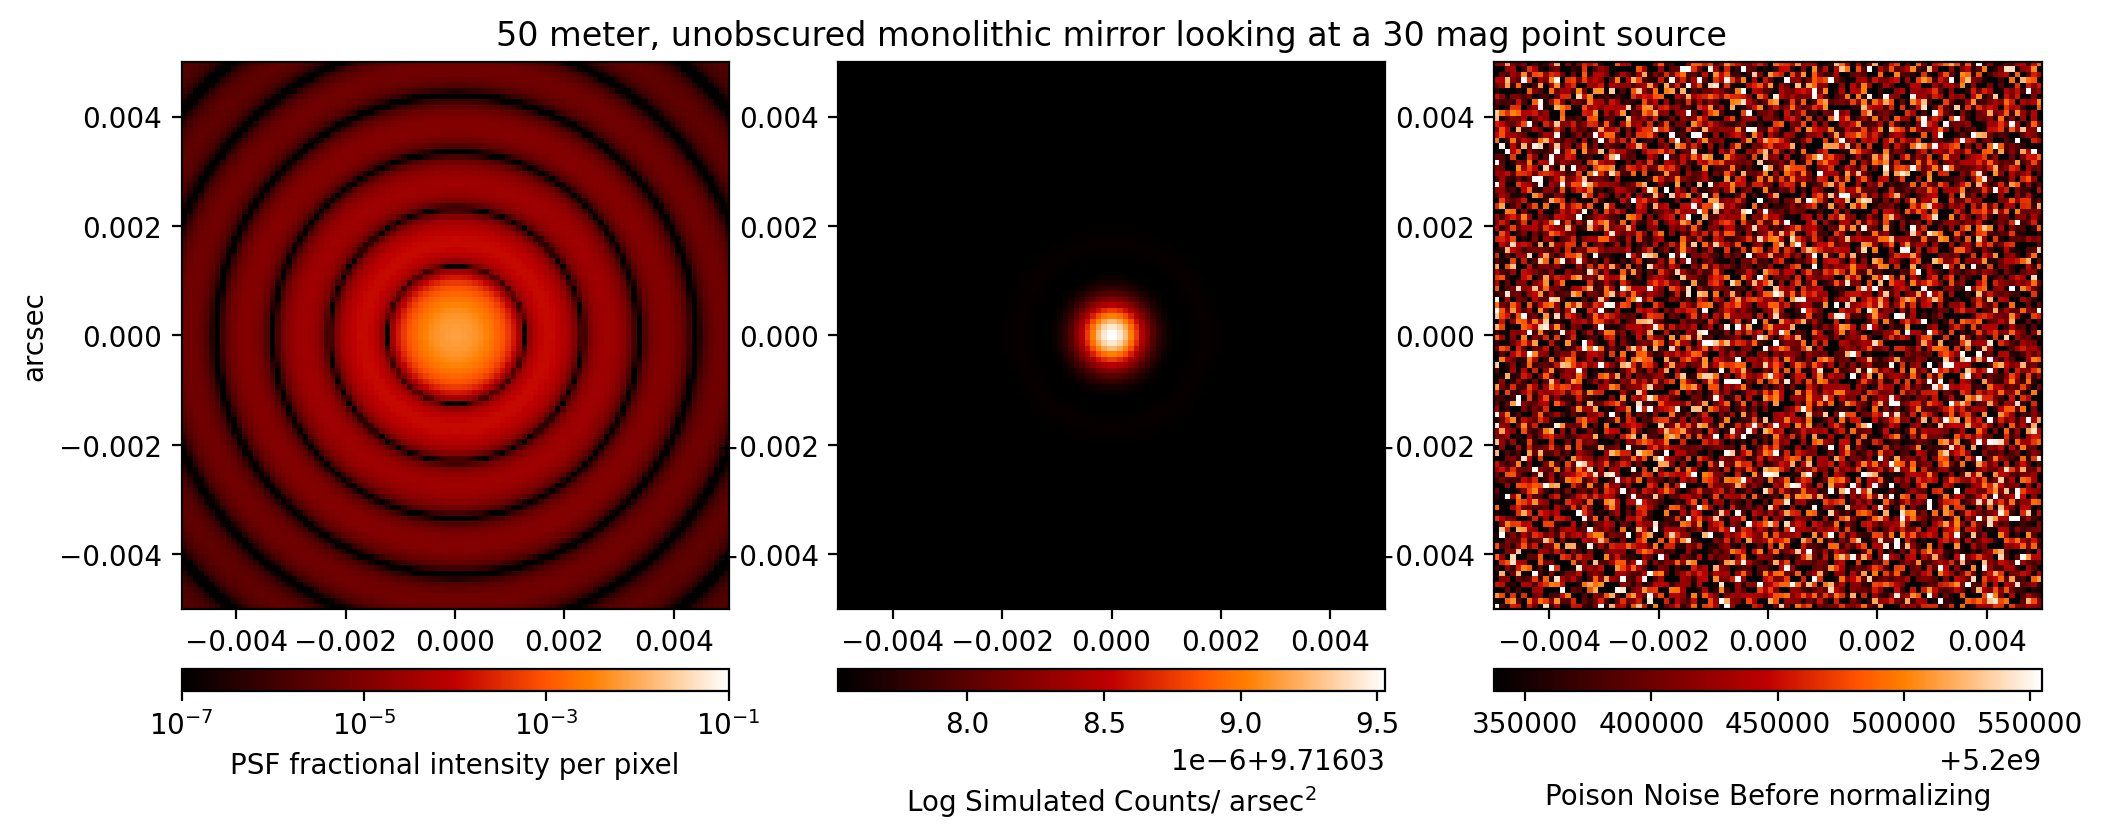

In [99]:
epsilon = 0.3
radius = 5e3 * u.cm  # cm
diam = 2 * radius.to(u.m)
mag = 30
aeff = epsilon * np.pi * (diam.value / 2) ** 2  # m2

dlambda = 1000.0  # Angstrom
texp = 1e5
sky_mag_asec2 = 22.0
pixelscale = 0.0002
fov_arcsec = 0.01  # fov on one side, so a 1x1 arcsec fov
wavelength = 0.5e-6

pupil_unobsc = poppy.CircularAperture(radius=diam.value / 2.0)

pupil = pupil_unobsc

im_sim, im_sim_poisson = image_simulator(
    mag,
    aeff,
    dlambda,
    texp,
    sky_mag_asec2,
    pupil,
    pixelscale,
    fov_arcsec,
    wavelength,
    title="50 meter, unobscured monolithic mirror looking at a 30 mag point source",
)
plt.show()

Total num photons from sky 3.2812364470418593
Sky background mean photons per pixel 0.0013124945788167439
Sky background mean counts per arcsec^2 32812.36447041859
source photon flux 1.3925999999999998e-13
source photon per arcsec^2 328.1236447041859
source total # photons 0.03281236447041859


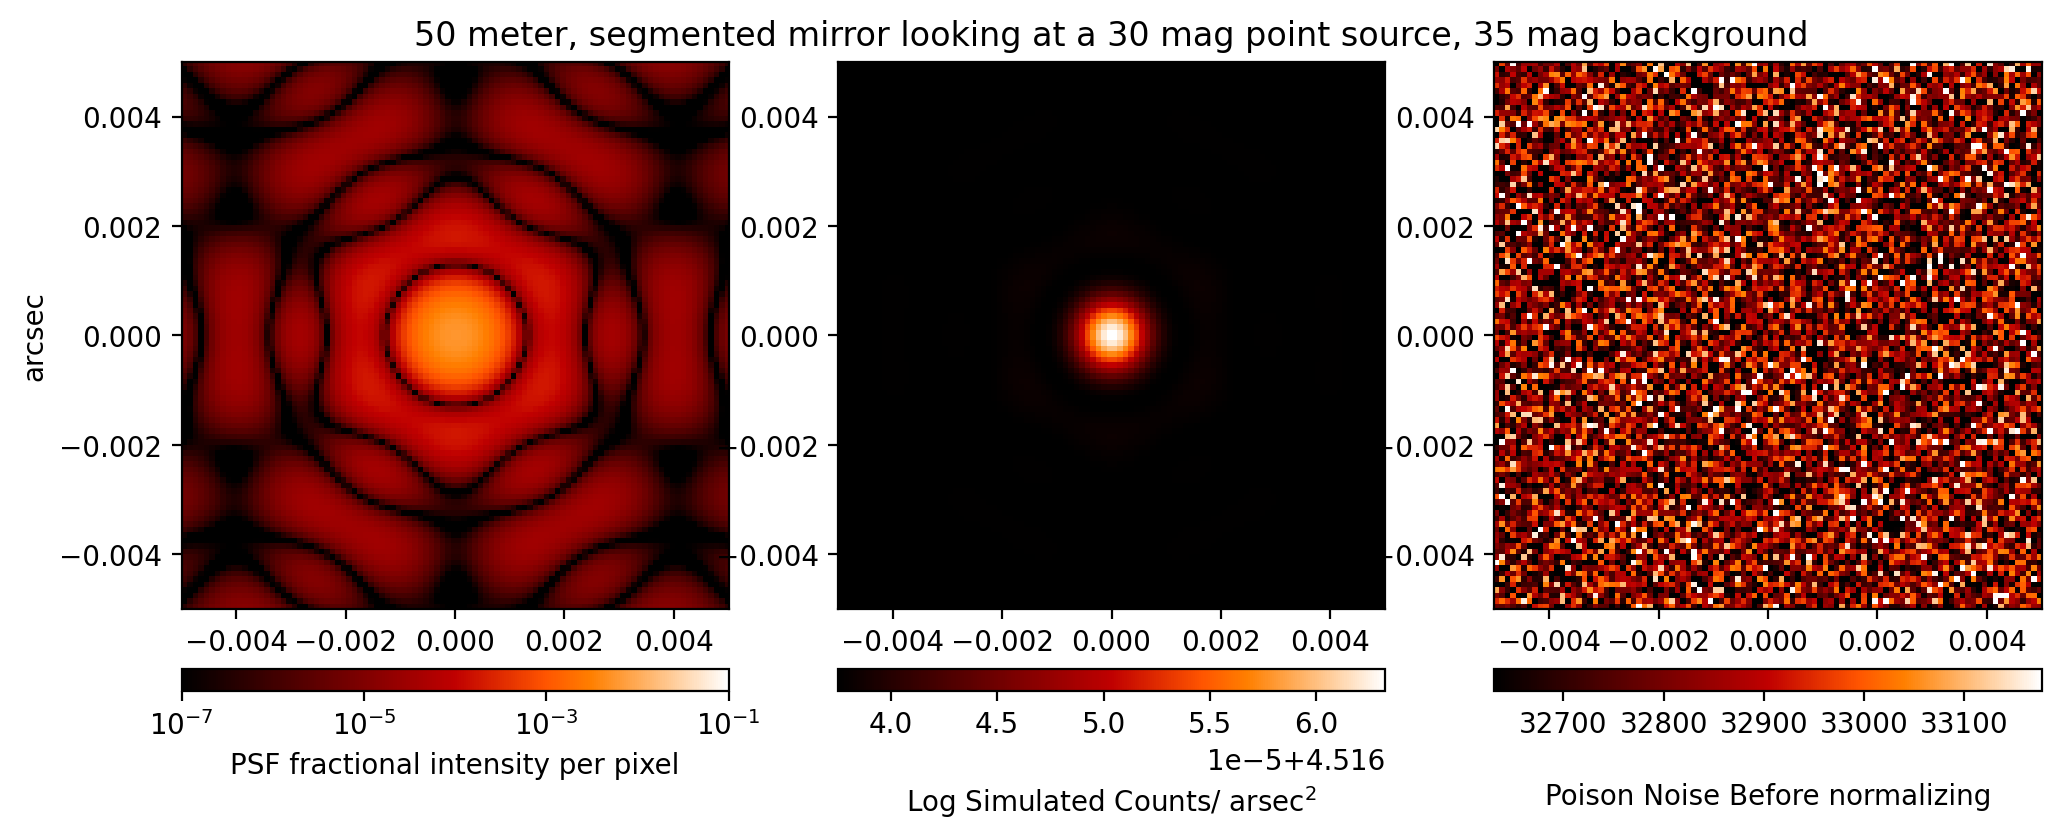

In [104]:
epsilon = 0.3
radius = 5e3 * u.cm  # cm
diam = 2 * radius.to(u.m)
mag = 40
aeff = epsilon * np.pi * (diam.value / 2) ** 2  # m2

dlambda = 1000.0  # Angstrom
texp = 1e5
sky_mag_asec2 = 35
pixelscale = 0.0002
fov_arcsec = 0.01  # fov on one side, so a 1x1 arcsec fov
wavelength = 0.5e-6

pupil_seg_ap = poppy.MultiHexagonAperture(
    rings=3, flattoflat=diam.value / 7, gap=diam.value / 200
)  # approx circumscribed diameter
pupil_seg_sec = poppy.SecondaryObscuration(
    secondary_radius=epsilon * diam.value / 2,
    n_supports=3,
    support_width=diam.value / 40,
)  # secondary with spiders
pupil_seg = poppy.CompoundAnalyticOptic(
    opticslist=[pupil_seg_ap, pupil_seg_sec], name="Segmented Aperture"
)  # combine into one optic

pupil = pupil_seg_ap

im_sim, im_sim_poisson = image_simulator(
    mag,
    aeff,
    dlambda,
    texp,
    sky_mag_asec2,
    pupil,
    pixelscale,
    fov_arcsec,
    wavelength,
    title="50 meter, segmented mirror looking at a 30 mag point source, 35 mag background",
)
plt.show()

```
2.  2030 Decadal Survey - Large telescope architecture

In class we discussed the tradeoffs for the choice of possible architectures and orbits/locations for the next large space telescope.  These included:

100m segmented observatory with secondary obscuration, situated at the L2 point (~1,5000,000 km from Earth)
50 m unobscured monolithic mirror (no segments), situated at the L2 point 
50 m segmented telescope situated near Neptune's orbit (sky background 30 times fainter), and colder temperatures
Given what you know at this point (e.g. based on the tools you have been using), which architecture might you choose, and briefly explain why?  Is there a specific science case that is driving your decision?
```

### Commentary

In the calculations above, we try the 100 m segmented, 50 m unobscured, and 50 m segmented but at a higher magnitude background (maybe at Neptune case). I had to play a little bit with the FOV, since if we make the mirrors larger, the object appears smalle and the psf can get duplicated and wonky.


I think for the case I am concerend about, which is hunting for the first stars, I think next generation 50 m space telescope that is segmented and at L2 would be good. I think space is the way to go because the duty cycle is much better than a ground based one. Segmented is also the way to go because it makes transportation easier. In terms of cooling, we won't need much in space, but maybe just a sun shield. I have also seen habitable worlds observatory rendering and the "barrel" looking shields.  